<a href="https://colab.research.google.com/github/edmenciab733/hackaton2023/blob/main/diagnostico_trastornos_edgar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Librerías 

Se instalan las librerías necesarias
- datasets
- ntlk 
- transformers
- peft


In [1]:
!pip install -q bitsandbytes datasets accelerate loralib
!pip install nltk
!pip install -q git+https://github.com/huggingface/transformers.git@main git+https://github.com/huggingface/peft.git
!pip install evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.2/84.2 MB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 KB 26.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.3/215.3 KB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 21.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 KB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 KB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 KB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 KB 3.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Installing

Se cargan las librerías necesariás

In [2]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from datasets import Dataset
import numpy as np
from datasets import load_metric
from transformers import Trainer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
import evaluate
from sklearn import metrics
import matplotlib.pyplot as plt

# Dataset
- Se carga stopwords
- Se carga el dataset Sintomas.xlsx
- Se convierte el los padecimientos en una variable númerica llamada Padecimiento_Cat
- Se crean los diccionarios  id2label - label2id para que el pipeline dé los resultados
- Se define el numero de posibles resultados

In [3]:
%%capture
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [5]:
data = pd.read_excel("Sintomas.xlsx")

In [6]:
labelencoder = LabelEncoder()
labelencoder.fit(data['Padecimiento'])
data['Padecimiento_Cat'] = labelencoder.transform(data['Padecimiento'])

In [7]:
labelencoder.transform(['Enuresis'])

array([0])

In [8]:
id2label = {}
label2id = {}
for i in labelencoder.classes_:
   id = labelencoder.transform([i])[0]
   id = str(id)
   id2label[id] = i
   label2id[i] = id

In [9]:
id2label, label2id

({'0': 'Enuresis',
  '1': 'Transtorno del sueño',
  '2': 'Trastorno Depresivo Mayor',
  '3': 'Trastorno de Ansiedad Debido a Otra Afección Médica',
  '4': 'Trastorno de Ansiedad Generalizada',
  '5': 'Trastorno de Ansiedad Social (Fobia Social)',
  '6': 'Trastorno por Abuso de Sustancias',
  '7': 'Trastornos de la conducta alimentaria no especificados',
  '8': 'Trastornos de la personalidad antisocial',
  '9': 'Trastornos de la personalidad borderline',
  '10': 'Trastornos de la personalidad esquizoide',
  '11': 'Trastornos de la personalidad esquizotípica',
  '12': 'Trastornos de la personalidad histriónica',
  '13': 'Trastornos de la personalidad narcisista',
  '14': 'Trastornos de la personalidad paraoide'},
 {'Enuresis': '0',
  'Transtorno del sueño': '1',
  'Trastorno Depresivo Mayor': '2',
  'Trastorno de Ansiedad Debido a Otra Afección Médica': '3',
  'Trastorno de Ansiedad Generalizada': '4',
  'Trastorno de Ansiedad Social (Fobia Social)': '5',
  'Trastorno por Abuso de Sustan

In [10]:
target_nro = len(labelencoder.classes_)
target_nro

15

In [11]:
data.head()

,Síntoma,Padecimiento,Padecimiento_Cat
0,El paciente experimenta preocupación por su co...,Trastornos de la conducta alimentaria no espec...,7
1,La preocupación del paciente por su alimentaci...,Trastornos de la conducta alimentaria no espec...,7
2,El paciente evita comer alimentos que contenga...,Trastornos de la conducta alimentaria no espec...,7
3,La preocupación del paciente por su peso o apa...,Trastornos de la conducta alimentaria no espec...,7
4,El paciente siente rechazo hacia los alimentos...,Trastornos de la conducta alimentaria no espec...,7


Resumen del balance de los datos

In [12]:
data.Padecimiento.value_counts()

Trastornos de la personalidad narcisista                  118
Trastornos de la personalidad histriónica                 100
Trastornos de la personalidad borderline                   98
Trastornos de la personalidad antisocial                   74
Trastornos de la personalidad esquizotípica                70
Enuresis                                                   68
Trastornos de la personalidad esquizoide                   47
Trastorno de Ansiedad Generalizada                         40
Trastorno de Ansiedad Social (Fobia Social)                40
Trastornos de la personalidad paraoide                     37
Trastornos de la conducta alimentaria no especificados     30
Trastorno Depresivo Mayor                                  30
Transtorno del sueño                                       23
Trastorno por Abuso de Sustancias                          20
Trastorno de Ansiedad Debido a Otra Afección Médica        19
Name: Padecimiento, dtype: int64

In [13]:
data = data.sample(frac=1).reset_index(drop=True)

In [14]:
data.head()

,Síntoma,Padecimiento,Padecimiento_Cat
0,Siempre sintiendo ansiedad en diversas áreas d...,Trastorno de Ansiedad Generalizada,4
1,Falta de control voluntario de la vejiga que p...,Enuresis,0
2,Constantemente ansioso sin una razón específica,Trastorno de Ansiedad Generalizada,4
3,Era extremadamente descuidado en cuanto a la s...,Trastornos de la personalidad antisocial,8
4,La persona se siente constantemente amenazada ...,Trastornos de la personalidad borderline,9


Nube de palabras para establecer los usos entender un poco el dataset

In [15]:
def nube_palabras(all_text): 
  wordcloud = WordCloud(width = 800, height = 800,
                  background_color ='white',
                  stopwords = stopwords,
                  min_font_size = 10).generate(all_text)

  plt.figure(figsize = (8, 8), facecolor = None)
  plt.imshow(wordcloud)
  plt.axis("off")
  plt.tight_layout(pad = 0)
  plt.show()

In [16]:
stopwords  = set(stopwords.words('spanish'))

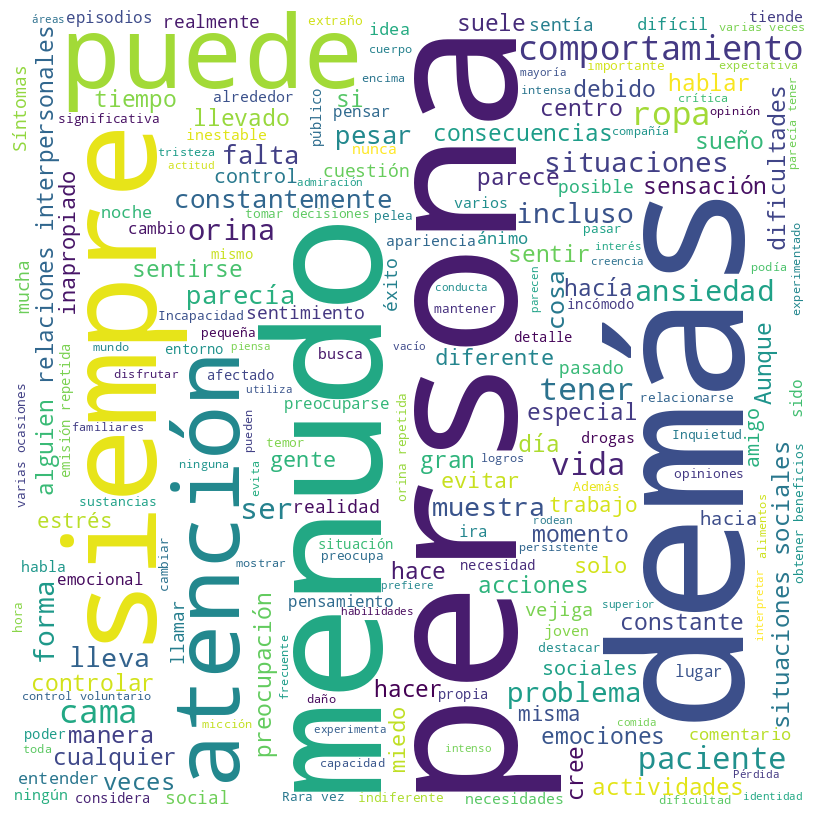

In [17]:
all_text = ' '.join(list(data["Síntoma"].values))
nube_palabras(all_text)
del all_text

# FineTuning
- Conversión de pandas a dataset(hugginface)
- Renombre de las columnas adecuedas
- Split train-test de los datos


In [18]:
dataset = Dataset.from_pandas(data)
dataset = dataset.rename_column("Síntoma", "text")
dataset = dataset.rename_column("Padecimiento_Cat", "label")

In [19]:
dataset= dataset.class_encode_column(
    "label"
).train_test_split(test_size=0.2, stratify_by_column="label")
dataset

Stringifying the column:   0%|          | 0/814 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/814 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'Padecimiento', 'label'],
        num_rows: 651
    })
    test: Dataset({
        features: ['text', 'Padecimiento', 'label'],
        num_rows: 163
    })
})

## Carga de los modelos
-  Carga dccuchile/bert-base-spanish-wwm-cased
-  Preparación de los paramestros de entrenamiento
-  Entrenamiento
-  Guarda de los modelos de entrenamientos


Carga del modelo ber en español

In [20]:
model_id="dccuchile/bert-base-spanish-wwm-cased"

In [21]:
tokenizer = AutoTokenizer.from_pretrained(model_id)

In [22]:
def tokenize_function(examples):
  return tokenizer(examples["text"], padding="max_length", truncation=True)

In [23]:
tokenized_datasets = dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/651 [00:00<?, ? examples/s]

Map:   0%|          | 0/163 [00:00<?, ? examples/s]

In [24]:
model = AutoModelForSequenceClassification.from_pretrained(model_id, num_labels=target_nro, id2label=id2label, label2id=label2id)

Some weights of the model checkpoint at dccuchile/bert-base-spanish-wwm-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchi

In [25]:
metric = evaluate.load("accuracy")

In [26]:
def compute_metrics(eval_pred):
  logits, labels = eval_pred
  predictions = np.argmax(logits, axis=-1)
  return metric.compute(predictions=predictions, references=labels)

In [27]:
from transformers import TrainingArguments
training_args = TrainingArguments(output_dir="test_trainer", evaluation_strategy="epoch")

In [28]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    compute_metrics=compute_metrics,
)

In [29]:
trainer.train()

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.665296,0.828221
2,No log,0.281469,0.920245
3,No log,0.254021,0.932515


TrainOutput(global_step=246, training_loss=0.6479841402875699, metrics={'train_runtime': 194.0476, 'train_samples_per_second': 10.065, 'train_steps_per_second': 1.268, 'total_flos': 513915869279232.0, 'train_loss': 0.6479841402875699, 'epoch': 3.0})

In [30]:
trainer.evaluate(tokenized_datasets["test"])

{'eval_loss': 0.2540214955806732,
 'eval_accuracy': 0.9325153374233128,
 'eval_runtime': 5.4382,
 'eval_samples_per_second': 29.973,
 'eval_steps_per_second': 3.862,
 'epoch': 3.0}

In [31]:
predict= trainer.predict(tokenized_datasets["test"])

In [32]:
preds = np.argmax(predict.predictions, axis=-1)

In [33]:
df_evaluate = pd.DataFrame(tokenized_datasets["test"] ) 
df_evaluate['prediction'] = preds

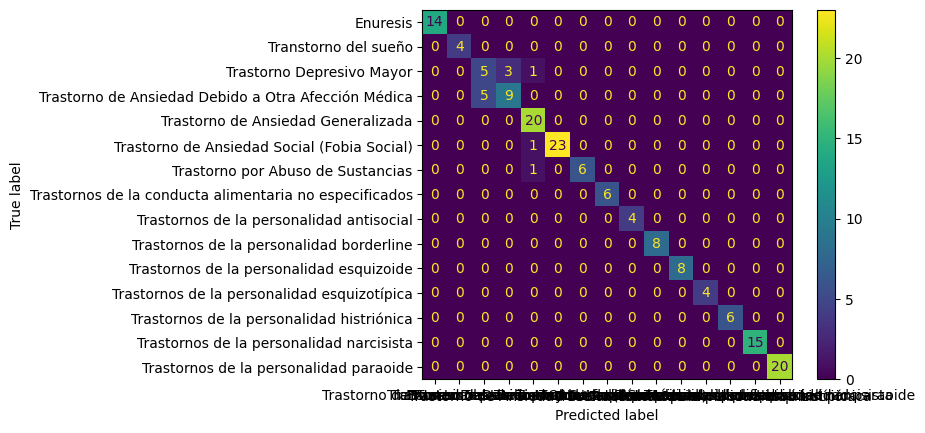

In [34]:
confusion_matrix = metrics.confusion_matrix(df_evaluate['label'], df_evaluate['prediction'])
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = labelencoder.classes_)
cm_display.plot()
plt.show()

In [35]:
model_id_custom = "./diagnotico_fine_tunning_transformer"
# Save tokenizer
tokenizer.save_pretrained(model_id_custom)
# Save model
trainer.save_model(model_id_custom)

# Testing Model

In [36]:
# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_id_custom)
# Load model
loaded_model = AutoModelForSequenceClassification.from_pretrained(model_id_custom)

In [37]:
from transformers import pipeline

In [38]:
classifier = pipeline("text-classification", model=model_id_custom )

In [43]:
classifier("El paciente no come frente a mucha gente, y normalmente tiene miedo a usar camisa ajustada")

[{'label': 'Trastornos de la personalidad histriónica',
  'score': 0.9389243125915527}]

In [40]:
classifier("El paciente come poco y usa camisa ajustada")

[{'label': 'Trastornos de la personalidad histriónica',
  'score': 0.6013009548187256}]